In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, confusion_matrix

#not sure if this is allowed
!python3 -m pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline # to tune sampling methods

#temporary
from collections import Counter

from model import FraudDetector

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
data = pd.read_csv("historical.csv")
data.head()

,tid,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,49b18cea-beb8-413d-b268-a0ec12a4147c,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0d1de000-6756-4441-8133-e0ed75b72979,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,dc548f8c-ecd2-4fee-8a80-f2de7e2c7bd6,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,f105abf5-0c4c-4e79-9a8a-59de254e58dc,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,164a2881-40c6-43ba-b53e-cd1e5a9e8cee,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


# EDA

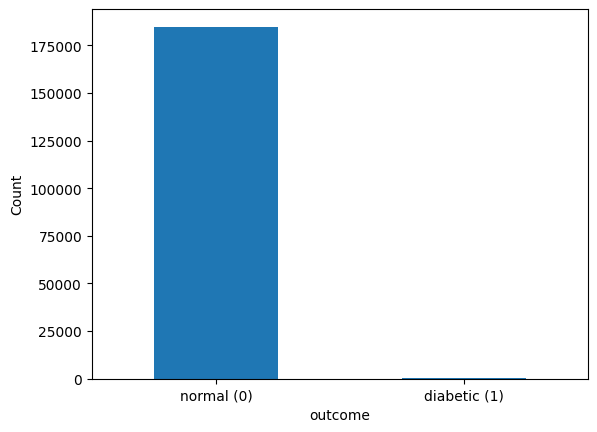

In [4]:
target = data["outcome"]
class_mapping = {0: "normal (0)", 1: "diabetic (1)"}
target.map(class_mapping).value_counts().plot.bar(rot=0)
plt.ylabel("Count")
plt.show()

<Axes: xlabel='V1', ylabel='V2'>

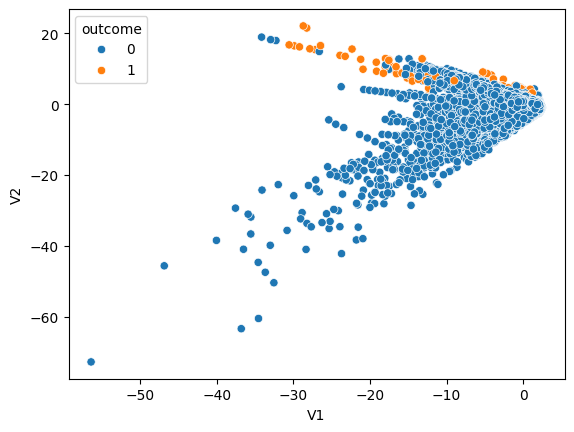

In [5]:
sns.scatterplot(x=data["V1"], y=data["V2"], hue=target)

In [6]:
target.value_counts()

outcome
0    184804
1       320
Name: count, dtype: int64

# Baseline: See results of Random Forest without balancing classes

In [7]:
# Separate features (PCA & Amount) from target
X, y = data.iloc[:, 1:-1], data.iloc[:, -1]

# 20% of entire data is the hold-out set
X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

# 20% of entire data is validation set while 60% is the train set
X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.25, random_state=0, stratify=y_Train
)

# print out the training and validation set sizes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (111074, 29)
X_val shape: (37025, 29)


## Without scaler

In [7]:
rf_untuned = Pipeline(
    [("clf", FraudDetector())]
)

rf_untuned.fit(X_train, y_train)

# Measure performance on validation set

rf_untuned_train = rf_untuned.predict(X_train) # We have to measure train performance manually
rf_untuned_val = rf_untuned.predict(X_val)   

In [8]:
print("==========Untuned Logistic Regression==========")
print(f"Training F1 Score: {f1_score(y_train, rf_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_untuned_val)))

==========Untuned Logistic Regression==========
Training F1 Score: 1.0000
Validation Set performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36961
           1       0.96      0.75      0.84        64

    accuracy                           1.00     37025
   macro avg       0.98      0.87      0.92     37025
weighted avg       1.00      1.00      1.00     37025

Validation Set Confusion Matrix:
        0   1
0  36959   2
1     16  48


## With Scaler (I don't think this is needed for Random Forest, but just be safe)

- Update: no changes. so just remove this in final report

In [61]:
rf_scaled_untuned = Pipeline(
    [("scaler", StandardScaler()),
     ("clf", FraudDetector())]
)

rf_scaled_untuned.fit(X_train, y_train)

# Measure performance on validation set

rf_scaled_untuned_train = rf_scaled_untuned.predict(X_train) # We have to measure train performance manually
rf_scaled_untuned_val = rf_scaled_untuned.predict(X_val)   

In [62]:
print("==========Untuned Logistic Regression==========")
print(f"Training F1 Score: {f1_score(y_train, rf_scaled_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_scaled_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_scaled_untuned_val)))

==========Untuned Logistic Regression==========
Training F1 Score: 1.0000
Validation Set performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36961
           1       0.96      0.75      0.84        64

    accuracy                           1.00     37025
   macro avg       0.98      0.87      0.92     37025
weighted avg       1.00      1.00      1.00     37025

Validation Set Confusion Matrix:
        0   1
0  36959   2
1     16  48


## Tuning through Stratified KFold (temporary)
- so far, model.py does not allow tuning of random forest parameters... so focus on model imbalance for now

In [ ]:
#[1e-5, 1e-3, 1e-2, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 20, 100] 
#[0.001, 0.01, 0.1, 1.0, 10, 100] 

In [80]:
"""rf_params = {
    'clf__n_estimators': [20, 50, 100],
    'clf__max_depth': [10, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
}"""

"rf_params = {\n    'clf__n_estimators': [20, 50, 100],\n    'clf__max_depth': [10, 20, 30, None],\n    'clf__min_samples_split': [2, 5, 10],\n    'clf__class_weight': [None, 'balanced', 'balanced_subsample'],\n}"

In [81]:
"""rf_tuning = Pipeline(
    [("clf", FraudDetector())]
)

# Stratify KFold to train model using train set
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

rcv = RandomizedSearchCV(rf_tuning, 
                         rf_params, 
                         random_state=0,
                         cv=skf)

search = rcv.fit(X_train, y_train)

best_lr_params = search.best_params_
lr_tuned = search.best_estimator_

# Measure performance on validation set
lr_tuned_train = lr_tuned.predict(X_train)
lr_tuned_val = lr_tuned.predict(X_val) """

'rf_tuning = Pipeline(\n    [("clf", FraudDetector())]\n)\n\n# Stratify KFold to train model using train set\nskf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)\n\nrcv = RandomizedSearchCV(rf_tuning, \n                         rf_params, \n                         random_state=0,\n                         cv=skf)\n\nsearch = rcv.fit(X_train, y_train)\n\nbest_lr_params = search.best_params_\nlr_tuned = search.best_estimator_\n\n# Measure performance on validation set\nlr_tuned_train = lr_tuned.predict(X_train)\nlr_tuned_val = lr_tuned.predict(X_val) '

In [ ]:
"""print("==========Untuned Logistic Regression==========")
print(f"Training F1 Score: {f1_score(y_train, rf_tuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_tuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_tuned_val)))""""

## Random Undersampling

In [10]:
seed = 39 # follows random state of model.py

In [10]:
us_model = Pipeline(
    [("clf", FraudDetector())]
)

In [11]:
# Let's create resampled X_train samples

# Note that we're using X_train -- the one where we don't have the validation set anymore
rus = RandomUnderSampler(random_state=seed)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [12]:
# Model Training
us_model.fit(X_train_us, y_train_us)

# Check on the validation set
us_preds = us_model.predict(X_val)

In [13]:
print("Random Under Sampling Performance on the Validation Set:\n")
print(f"Training F1 Score: {f1_score(y_val, us_preds):.4f}")
print(classification_report(y_val, us_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, us_preds)))

Random Under Sampling Performance on the Validation Set:

Training F1 Score: 0.1005
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     36961
           1       0.05      0.94      0.10        64

    accuracy                           0.97     37025
   macro avg       0.53      0.95      0.54     37025
weighted avg       1.00      0.97      0.98     37025

Validation Set Confusion Matrix:
        0     1
0  35891  1070
1      4    60


## Random Oversampling

In [14]:
os_model = Pipeline(
    [("clf", FraudDetector())]
)

In [15]:
# Let's create resampled X_train samples

# Note that we're using X_train -- the one where we don't have the validation set anymore
ros = RandomOverSampler(random_state=seed)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

In [16]:
# Model Training
os_model.fit(X_train_os, y_train_os)

# Check on the validation set
os_preds = os_model.predict(X_val)

In [17]:
print("Random Over Sampling Performance on the Validation Set:\n")
print(f"Training F1 Score: {f1_score(y_val, os_preds):.4f}")
print(classification_report(y_val, os_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, os_preds)))

Random Over Sampling Performance on the Validation Set:

Training F1 Score: 0.8522
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36961
           1       0.96      0.77      0.85        64

    accuracy                           1.00     37025
   macro avg       0.98      0.88      0.93     37025
weighted avg       1.00      1.00      1.00     37025

Validation Set Confusion Matrix:
        0   1
0  36959   2
1     15  49


very minimal improvement (0.75 -> 0.77)

## SMOTE Untuned

In [8]:
smote_model = Pipeline(
    [("clf", FraudDetector())]
)

In [13]:
#needed for cores in macbook

import os
import multiprocessing

# This gives logical cores
n_logical = multiprocessing.cpu_count()

# Use logical as fallback (since physical detection requires psutil)
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_logical)

print(f"LOKY_MAX_CPU_COUNT set to {n_logical} (logical cores)")


LOKY_MAX_CPU_COUNT set to 8 (logical cores)


In [14]:
# Let's create resampled X_train samples

smote = SMOTE(random_state=seed, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [15]:
smote_model.fit(X_train_smote, y_train_smote)
smote_preds = smote_model.predict(X_val)

In [16]:
print("SMOTE Sampling Performance on the Validation Set:\n")
print(classification_report(y_val, smote_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, smote_preds)))

SMOTE Sampling Performance on the Validation Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36961
           1       0.87      0.86      0.87        64

    accuracy                           1.00     37025
   macro avg       0.94      0.93      0.93     37025
weighted avg       1.00      1.00      1.00     37025

Validation Set Confusion Matrix:
        0   1
0  36953   8
1      9  55


Class instance count before SMOTE: Counter({0: 110882, 1: 192})
Class instance count after SMOTE: Counter({0: 110882, 1: 110882})
-----------------------------------------------------------------


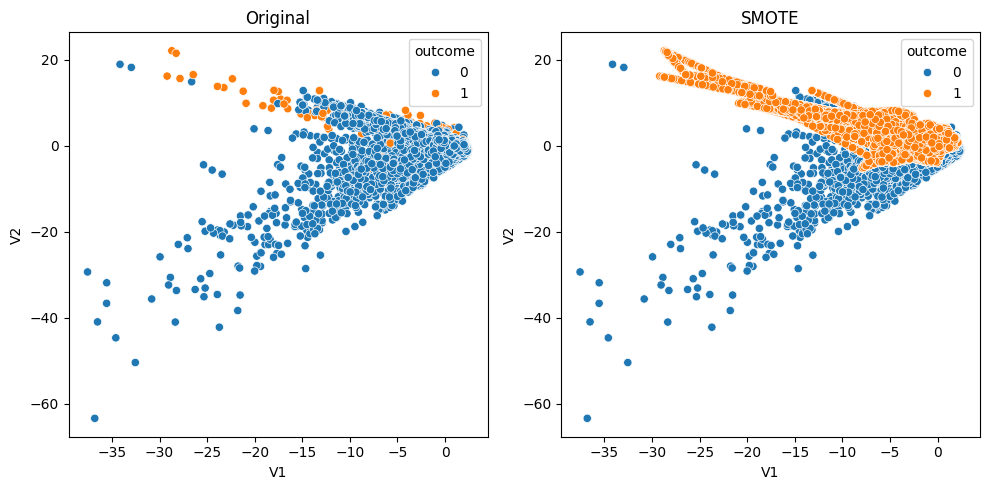

In [18]:
print(f"Class instance count before SMOTE: {Counter(y_train)}")
print(f"Class instance count after SMOTE: {Counter(y_train_smote)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_smote]

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "SMOTE"]
targets = [y_train, y_train_smote]
for i, ax in enumerate(axes):
    curr_data = datasets[i]
    sns.scatterplot(x=curr_data.iloc[:, 0],y=curr_data.iloc[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

## SMOTE Tuned

In [19]:
smote_tuning_model = imb_pipeline(
    [
        ("smote", SMOTE(random_state=seed)),
        ("clf", FraudDetector())
    ]
)

In [20]:
params = {"smote__k_neighbors": range(1, 11)}

# Model training
skf = StratifiedKFold(n_splits=5, random_state=32, shuffle=True)

rcv = RandomizedSearchCV(smote_tuning_model, params, random_state=seed, scoring='f1', cv=skf)
search = rcv.fit(X_train, y_train)

best_smote_params = search.best_params_
print(best_smote_params)

{'smote__k_neighbors': 8}


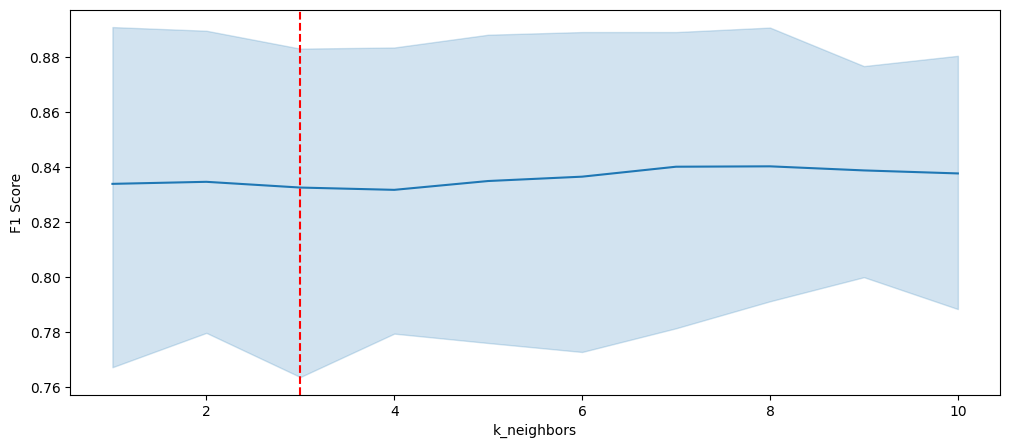

In [ ]:
cv_scores = { key.split("_")[0] : value for key, value in search.cv_results_.items() if "split" in key }
train_scores = pd.DataFrame(cv_scores)
train_scores["k"] = range(1, 11)

flat_df = train_scores.melt(id_vars="k")

plt.figure(figsize=(12, 5))
sns.lineplot(data=flat_df, x="k", y="value")
#plt.axvline(3, linestyle="--", color="red", alpha=1)
plt.ylabel("F1 Score")
plt.xlabel("k_neighbors")
plt.show()

In [22]:
print(cv_scores)

{'split0': array([0.83333333, 0.82191781, 0.82191781, 0.81081081, 0.81081081,
       0.82666667, 0.82666667, 0.85333333, 0.83116883, 0.83116883]), 'split1': array([0.82191781, 0.82191781, 0.83783784, 0.82666667, 0.83783784,
       0.83783784, 0.83783784, 0.83783784, 0.83783784, 0.83783784]), 'split2': array([0.86486486, 0.88      , 0.88      , 0.88      , 0.86842105,
       0.88311688, 0.88311688, 0.85714286, 0.86075949, 0.86075949]), 'split3': array([0.71641791, 0.71641791, 0.71428571, 0.73239437, 0.72463768,
       0.71428571, 0.73239437, 0.73239437, 0.76712329, 0.75      ]), 'split4': array([0.93333333, 0.93333333, 0.90909091, 0.90909091, 0.93333333,
       0.92105263, 0.92105263, 0.92105263, 0.8974359 , 0.90909091])}


In [23]:
print(flat_df)

     k variable     value
0    1   split0  0.833333
1    2   split0  0.821918
2    3   split0  0.821918
3    4   split0  0.810811
4    5   split0  0.810811
5    6   split0  0.826667
6    7   split0  0.826667
7    8   split0  0.853333
8    9   split0  0.831169
9   10   split0  0.831169
10   1   split1  0.821918
11   2   split1  0.821918
12   3   split1  0.837838
13   4   split1  0.826667
14   5   split1  0.837838
15   6   split1  0.837838
16   7   split1  0.837838
17   8   split1  0.837838
18   9   split1  0.837838
19  10   split1  0.837838
20   1   split2  0.864865
21   2   split2  0.880000
22   3   split2  0.880000
23   4   split2  0.880000
24   5   split2  0.868421
25   6   split2  0.883117
26   7   split2  0.883117
27   8   split2  0.857143
28   9   split2  0.860759
29  10   split2  0.860759
30   1   split3  0.716418
31   2   split3  0.716418
32   3   split3  0.714286
33   4   split3  0.732394
34   5   split3  0.724638
35   6   split3  0.714286
36   7   split3  0.732394
37   8   spl

## Kalats Incorrect versions

In [116]:
rf_untuned = Pipeline(
    [("clf", FraudDetector("undersample"))]
)

rf_untuned.fit(X_train, y_train)

rf_untuned_train = rf_untuned.predict(X_train) # We have to measure train performance manually
rf_untuned_val = rf_untuned.predict(X_val) 

Counter({0: 110882, 1: 192}) Counter({0: 192, 1: 192})


In [117]:
print("==========Undersampling==========")
print(f"Training F1 Score: {f1_score(y_train, rf_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_untuned_val)))

==========Undersampling==========
Training F1 Score: 0.1009
Validation Set performance:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     36961
           1       0.05      0.94      0.10        64

    accuracy                           0.97     37025
   macro avg       0.53      0.95      0.54     37025
weighted avg       1.00      0.97      0.98     37025

Validation Set Confusion Matrix:
        0     1
0  35891  1070
1      4    60


tldr: f1 score for the fraud is really bad (mainly due to the precision metric)

In [118]:
rf_untuned = Pipeline(
    [("clf", FraudDetector("oversample"))]
)

rf_untuned.fit(X_train, y_train)

rf_untuned_train = rf_untuned.predict(X_train) # We have to measure train performance manually
rf_untuned_val = rf_untuned.predict(X_val) 

Counter({0: 110882, 1: 192}) Counter({0: 110882, 1: 110882})


KeyboardInterrupt: 

In [112]:
print("==========Undersampling==========")
print(f"Training F1 Score: {f1_score(y_train, rf_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_untuned_val)))

==========Undersampling==========
Training F1 Score: 0.1069
Validation Set performance:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     36961
           1       0.06      0.94      0.11        64

    accuracy                           0.97     37025
   macro avg       0.53      0.96      0.55     37025
weighted avg       1.00      0.97      0.98     37025

Validation Set Confusion Matrix:
        0     1
0  35945  1016
1      4    60
